# BEST SYMBOLIC ODE GENERATOR:

In [ ]:
import numpy as np

def padded_binary(i: int, n: int) -> str:
    return bin(i)[2:].zfill(n)

# Replace this method in your class
@staticmethod
def binary_string_to_array(string: str) -> np.ndarray:
    # use a comprehension so we don't rely on the builtin `list` name being callable
    return np.array([int(ch) for ch in string], dtype=int)

def calculate_valid_transitions(n: int):
    num_states = 2**n
    all_states = [padded_binary(i, n) for i in range(num_states)]
    
    # print(f"Total number of states: {num_states}")
    # print("Valid single-step transitions:")

    valid_difference_vectors = set()
    
    valid_X_reactions = [] # distributively
    valid_Y_reactions = [] # distributively

    for i in range(num_states):
        for j in range(num_states):
            # Do not consider transitions from a state to itself
            if i == j:
                continue

            if np.sum(np.abs(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]))) == 1:
                # Determine if it's a phosphorylation or dephosphorylation event
                # A +1 indicates phosphorylation, a -1 indicates dephosphorylation
                element = "X" if np.any(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i]) == 1) else "Y"
                
                if element == "X":
                    print(f"{all_states[i]} -> {all_states[j]} ({element}), {i} -> {j}")
                    valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                if element == "Y":
                    print(f"{all_states[i]} -> {all_states[j]} ({element}), {i} -> {j}")
                    valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])

                valid_difference_vectors.add(tuple(binary_string_to_array(all_states[j]) - binary_string_to_array(all_states[i])))

    return valid_X_reactions, valid_Y_reactions

import numpy as np
import sympy as sp
from typing import Dict

def generate_odes(n: int) -> Dict[sp.Symbol, sp.Expr]:
    if n <= 0:
        raise ValueError("n must be a positive integer")

    valid_X_reactions, valid_Y_reactions = calculate_valid_transitions(n)
    num_states = 2**n 

    # symbolic objects
    E = sp.Symbol('E'); F = sp.Symbol('F')
    S = sp.IndexedBase('S')
    ES = sp.IndexedBase('ES'); EdotS = sp.IndexedBase('E.S')
    FS = sp.IndexedBase('FS'); FdotS = sp.IndexedBase('F.S')

    a_E = sp.IndexedBase('a^E'); a_F = sp.IndexedBase('a^F')
    b_E = sp.IndexedBase('b^E'); b_F = sp.IndexedBase('b^F')
    c_E = sp.IndexedBase('c^E'); c_F = sp.IndexedBase('c^F')

    d_dt = {}

    cE_out = {}
    for _, _, k, j, _ in valid_X_reactions:
        cE_out.setdefault(k, []).append(j)
    cF_out = {}
    for _, _, k, j, _ in valid_Y_reactions:
        cF_out.setdefault(k, []).append(j)

    cE_in = {}
    for _, _, k, j, _ in valid_X_reactions:
        cE_in.setdefault(j, []).append(k)
    cF_in = {}
    for _, _, k, j, _ in valid_Y_reactions:
        cF_in.setdefault(j, []).append(k)

    for i in range(0, num_states):

        d_dt[S[i]] = 0 
        
        if 0 <= i < num_states - 1:
            d_dt[S[i]] += b_E[i] * ES[i] - a_E[i] * E * S[i]

        if 0 < i <= num_states:
            d_dt[S[i]] += b_F[i] * FS[i] - a_F[i] * F * S[i]

        sum_cE = sum(c_E[k, i] * ES[k] for k in cE_in.get(i, [])) if i in cE_in else 0
        sum_cF = sum(c_F[k, i] * FS[k] for k in cF_in.get(i, [])) if i in cF_in else 0

        d_dt[S[i]] += sum_cE + sum_cF

    for i in range(0, num_states - 1):
        sum_c_E_ij = sum(c_E[i, j] for j in cE_out.get(i, [])) if i in cE_out else 0
        d_dt[ES[i]] = a_E[i] * E * S[i] - (b_E[i] + sum_c_E_ij) * ES[i]

    for i in range(1, num_states):
        sum_c_F_ij = sum(c_F[i, j] for j in cF_out.get(i, [])) if i in cF_out else 0
        d_dt[FS[i]] = a_F[i] * F * S[i] - (b_F[i] + sum_c_F_ij) * FS[i]

    d_dt[E] = sum(
        -a_E[j] * E * S[j]
        + (b_E[j] + (sum(c_E[j, k] for k in cE_out.get(j, [])) if j in cE_out else 0)) * ES[j]
        for j in range(0, num_states - 1)  
    )

    d_dt[F] = sum(
        -a_F[j] * F * S[j]
        + (b_F[j] + (sum(c_F[j, k] for k in cF_out.get(j, [])) if j in cF_out else 0)) * FS[j]
        for j in range(1, num_states)  
    )

    return d_dt

import sympy as sp

def remap_odes(odes: dict) -> dict:
    # old symbols
    E = sp.Symbol('E'); F = sp.Symbol('F')
    S = sp.IndexedBase('S')
    ES = sp.IndexedBase('ES')
    FS = sp.IndexedBase('FS')
    a_E = sp.IndexedBase('a^E'); a_F = sp.IndexedBase('a^F')
    b_E = sp.IndexedBase('b^E'); b_F = sp.IndexedBase('b^F')
    c_E = sp.IndexedBase('c^E'); c_F = sp.IndexedBase('c^F')

    # new symbols
    X = sp.Symbol('x'); Y = sp.Symbol('y')
    A = sp.IndexedBase('a')
    B = sp.IndexedBase('b')
    C = sp.IndexedBase('c')
    k_plus   = sp.IndexedBase('k^+')
    p_plus   = sp.IndexedBase('p^+')
    k_minus  = sp.IndexedBase('k^-')
    p_minus  = sp.IndexedBase('p^-')
    alpha    = sp.IndexedBase('alpha')
    beta     = sp.IndexedBase('beta')

    mapping = {
        E: X, F: Y,
        S: A, ES: B, FS: C,
        a_E: k_plus, a_F: p_plus,
        b_E: k_minus, b_F: p_minus,
        c_E: alpha,  c_F: beta
    }

    # apply replacement to keys and values
    remapped = {k.xreplace(mapping): v.xreplace(mapping) for k, v in odes.items()}
    return remapped


# Example usage
n = 1
odes = generate_odes(n)
odes_remapped = remap_odes(odes)

for k, v in odes_remapped.items():
    print(k, "->", v)

0 --> 1 (X), 0, 1
1 --> 0 (Y), 1, 0
a[0] -> -x*a[0]*k^+[0] + b[0]*k^-[0] + beta[1, 0]*c[1]
a[1] -> -y*a[1]*p^+[1] + alpha[0, 1]*b[0] + c[1]*p^-[1]
b[0] -> x*a[0]*k^+[0] - (alpha[0, 1] + k^-[0])*b[0]
c[1] -> y*a[1]*p^+[1] - (beta[1, 0] + p^-[1])*c[1]
x -> -x*a[0]*k^+[0] + (alpha[0, 1] + k^-[0])*b[0]
y -> -y*a[1]*p^+[1] + (beta[1, 0] + p^-[1])*c[1]


In [81]:
X = sp.Symbol('x'); Y = sp.Symbol('y'); a = sp.IndexedBase('b'); B = sp.IndexedBase('b'); C = sp.IndexedBase('c')
k_plus = sp.IndexedBase('k^+'); p_plus = sp.IndexedBase('p^+'); k_minus = sp.IndexedBase('k^-'); p_minus = sp.IndexedBase('p^-'); alpha = sp.IndexedBase('alpha'); beta = sp.IndexedBase('beta')
odes_remapped[a[0]]


x*a[0]*k^+[0] - (alpha[0, 1] + k^-[0])*b[0]

In [27]:
odes_remapped[X]


-X*A[0]*k^+[0] - X*A[1]*k^+[1] - X*A[2]*k^+[2] + (alpha[1, 3] + k^-[1])*B[1] + (alpha[2, 3] + k^-[2])*B[2] + (alpha[0, 1] + alpha[0, 2] + k^-[0])*B[0]

In [3]:
from sympy import solve
X = sp.Symbol('X'); Y = sp.Symbol('Y'); A = sp.IndexedBase('A'); B = sp.IndexedBase('B'); C = sp.IndexedBase('C')
k_plus = sp.IndexedBase('k^+'); p_plus = sp.IndexedBase('p^+'); k_minus = sp.IndexedBase('k^-'); p_minus = sp.IndexedBase('p^-'); alpha = sp.IndexedBase('alpha'); beta     = sp.IndexedBase('beta')

system = [odes_remapped[A[0]], odes_remapped[A[1]], odes_remapped[B[0]], odes_remapped[C[1]], odes_remapped[X], odes_remapped[Y]]

solution = solve(system, A[0], A[1], B[0], C[1], X, Y, dict=True)
solution

KeyboardInterrupt: 

In [ ]:
solution[0][A[0]]

Y*(alpha[0, 1] + k^-[0])*A[1]*beta[1, 0]*p^+[1]/(X*(beta[1, 0] + p^-[1])*alpha[0, 1]*k^+[0])

## BEST:

In [284]:
import numpy as np
import sympy as sp
from typing import List, Tuple, Dict, Any, Set

class all_parameter_generation:
    """
    Generate state transitions and random parameters (a, b, c, enzyme) for an n-site phosphorylation model.

    Args:
        n: number of sites (int)
        distribution: distribution name ("gamma" supported)
        params: parameters for the distribution (for gamma: [shape, scale])
        verbose: if True, prints transitions and matrices
    """
    def __init__(self, n: int, distribution: str = "gamma", distribution_paramaters: List[float] = [1.0, 1.0],
                 verbose: bool = False):
        self.n = n
        self.num_states = 2 ** n
        self.distribution = distribution
        self.params = distribution_paramaters
        self.verbose = verbose
        self.rng = np.random.default_rng()

    @staticmethod
    def padded_binary(i: int, n: int) -> str:
        return bin(i)[2:].zfill(n)

    @staticmethod
    def binary_string_to_array(string: str) -> np.ndarray:
        return np.array([int(i) for i in string], dtype=int)

    def calculate_valid_transitions(self) -> Tuple[List[List[Any]], List[List[Any]]]:
        """
        Returns:
            valid_X_reactions: list of [state_i_str, state_j_str, i, j, "E"]
            valid_Y_reactions: list of [state_i_str, state_j_str, i, j, "F"]
        """
        all_states = [self.padded_binary(i, self.n) for i in range(self.num_states)]

        valid_difference_vectors: Set[Tuple[int, ...]] = set()
        valid_X_reactions: List[List[Any]] = []
        valid_Y_reactions: List[List[Any]] = []

        for i in range(self.num_states):
            arr_i = self.binary_string_to_array(all_states[i])
            for j in range(self.num_states):
                if i == j:
                    continue
                arr_j = self.binary_string_to_array(all_states[j])
                diff = arr_j - arr_i
                if np.sum(np.abs(diff)) == 1:
                    # +1 -> phosphorylation (E), -1 -> dephosphorylation (F)
                    element = "E" if np.any(diff == 1) else "F"
                    if element == "E":
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (E), {i}, {j}")
                        valid_X_reactions.append([all_states[i], all_states[j], i, j, element])
                    else:
                        if self.verbose:
                            print(f"{all_states[i]} --> {all_states[j]} (F), {i}, {j}")
                        valid_Y_reactions.append([all_states[i], all_states[j], i, j, element])
                    valid_difference_vectors.add(tuple(diff))

        return valid_X_reactions, valid_Y_reactions
    
    def alpha_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params

        alpha_matrix = np.zeros((self.num_states, self.num_states))

        alpha_out: Dict[int, List[int]] = {}
        for _, _, i, j, _ in valid_X_reactions:
            alpha_out.setdefault(i, []).append(j)
            alpha_matrix[i][j] = self.rng.gamma(shape, scale)

        return alpha_matrix

    def beta_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray,
                                            Dict[int, List[int]], Dict[int, List[int]],
                                            Dict[int, List[int]], Dict[int, List[int]]]:
        
        valid_X_reactions, valid_Y_reactions = self.calculate_valid_transitions()

        shape, scale = self.params
        beta_matrix = np.zeros((self.num_states, self.num_states))
        
        for _, _, i, j, _ in valid_Y_reactions:
            beta_matrix[i][j] = self.rng.gamma(shape, scale)

        return beta_matrix
    
    def k_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        if self.distribution != "gamma":
            raise NotImplementedError("Only 'gamma' distribution implemented for a_parameter_generation")
        shape, scale = self.params
        k_positive_rates = self.rng.gamma(shape, scale, self.num_states)
        k_negative_rates = self.rng.gamma(shape, scale, self.num_states)
        k_positive_rates[2**self.n - 1] = 0
        k_negative_rates[2**self.n - 1] = 0
        return k_positive_rates, k_negative_rates

    def p_parameter_generation(self) -> Tuple[np.ndarray, np.ndarray]:
        
        if self.distribution != "gamma":
            raise NotImplementedError("Only 'gamma' distribution implemented for b_parameter_generation")
        shape, scale = self.params
        p_positive_rates = self.rng.gamma(shape, scale, self.num_states)
        p_negative_rates = self.rng.gamma(shape, scale, self.num_states)
        p_positive_rates[0] = 0
        p_negative_rates[0] = 0

        return p_positive_rates, p_negative_rates

# BEST METHOD KEEP THIS:

final A_0 = 6.161481290858513
final A_1 = 0.2012706623172386
final B_0 = 3.0904500439303377
final C_0 = 1.5467980028939132
final X = 1.909549956069666
final Y = 4.453201997106084


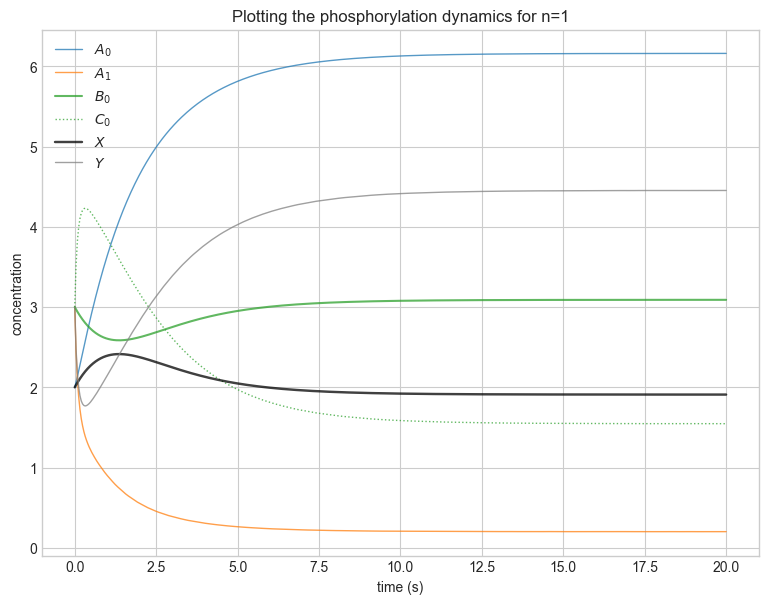

In [ ]:
import numpy as np

def generate_phosphorylation_ODES(t, state_array, n,
                                  alpha_matrix, beta_matrix,
                                  k_positive_rates, k_negative_rates,
                                  p_positive_rates, p_negative_rates):

    N = 2**n
    if state_array.size != 3 * N + 2:
        raise ValueError(f"Expected state_array length {3 * N + 2}, got {state_array.size} for n={n}")

    if k_positive_rates[-1] != 0 or k_negative_rates[-1] != 0:
        raise ValueError("Manual error raised: k_positive_rates[-1] and k_negative_rates[-1] must be zero to enforce boundary condition b_n = 0")
    
    if p_positive_rates[0] != 0 or p_negative_rates[0] != 0:
        raise ValueError("Manual error raised: p_positive_rates[0] and p_negative_rates[0] must be zero to enforce boundary condition c_0 = 0")
    
    a = state_array[0: N].astype(float)
    b = state_array[N: 2*N].astype(float)
    c = state_array[2*N: 3*N].astype(float)
    x = float(state_array[-2])
    y = float(state_array[-1])

    if b[-1] != 0 or c[0] != 0:
        raise ValueError("Manual error raised: b_n must be 0 and c_0 must be 0 at all times")
    
    K_positive_matrix = np.diag(k_positive_rates)
    k_negative_matrix = np.diag(k_negative_rates)
    p_positive_matrix = np.diag(p_positive_rates)
    p_negative_matrix = np.diag(p_negative_rates)

    ones_vec = np.ones(N)
    diagonal_loss_alpha_matrix = np.diag(alpha_matrix @ ones_vec)
    diagonal_loss_beta_matrix  = np.diag(beta_matrix  @ ones_vec)

    a_dot = (k_negative_matrix @ b) + (p_negative_matrix @ c) + (alpha_matrix.T @ b) + (beta_matrix.T @ c) \
            - x * (K_positive_matrix @ a) - y * (p_positive_matrix @ a)
    
    b_dot = x * (K_positive_matrix @ a) - (k_negative_matrix @ b) - diagonal_loss_alpha_matrix @ b
    c_dot = y * (p_positive_matrix @ a) - (p_negative_matrix @ c) - diagonal_loss_beta_matrix @ c

    # Enforce boundary conditions for all time: b_n = 0 and c_0 = 0
    b_dot[-1] = 0
    c_dot[0] = 0

    # To ensure that the sums in x and y dot dont go over incorrect indices, 
    # we zero out the last element of a for x_dot and the first element of a for y_dot
    a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    x_dot = -x * (k_positive_rates.T @ a_adjusted_for_x_dot) + (ones_vec.T @ ((k_negative_matrix + diagonal_loss_alpha_matrix) @ b))
    y_dot = -y * (p_positive_rates.T @ a_adjusted_for_y_dot) + (ones_vec.T @ ((p_negative_matrix + diagonal_loss_beta_matrix) @ c))

    # uncomment this code to check conservation
    # conserved_rate = ones_vec @ (a_dot + b_dot + c_dot)
    # if conserved_rate <= 1e-10:  # should be ~0 (mod numerical error)
    # check kinase conservation
    # print("dX_tot/dt =", x_dot + ones_vec @ b_dot)
    # # check phosphatase conservation
    # print("dY_tot/dt =", y_dot + ones_vec @ c_dot)

    return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))

n = 1
N = 2**n

gen = all_parameter_generation(n, distribution = "gamma", distribution_paramaters = (1, 1), verbose=False)

#####################
alpha_matrix = gen.alpha_parameter_generation()
beta_matrix= gen.beta_parameter_generation()
k_positive_rates, k_negative_rates = gen.k_parameter_generation()
p_positive_rates, p_negative_rates = gen.p_parameter_generation()

# print("alpha_matrix:\n", alpha_matrix)
# print("beta_matrix:\n", beta_matrix)
# print("k_positive_rates:", k_positive_rates)
# print("k_negative_rates:", k_negative_rates)
# print("p_positive_rates:", p_positive_rates)
# print("p_negative_rates:", p_negative_rates)
#####################

params = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)

# creating initial_state_array, and enforce that B_n = 0 and C_0 = 0
initial_states_array = np.random.randint(2, 4, 3 * (2**n) + 2)
initial_states_array[2 * N - 1] = 0
initial_states_array[2 * N] = 0
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

t_span = (0, 20); t_array = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(generate_phosphorylation_ODES, t_span = t_span, t_eval = t_array, y0=np.asarray(initial_states_array, dtype=float), args = params)

num_phos = len(sol.y)
a_solution_stack = np.stack([sol.y[i] for i in range(0, N)])
b_solution_stack = np.stack([sol.y[i] for i in range(N, 2*N - 1)]) # dont want to extract the b_n = 0 solution
c_solution_stack = np.stack([sol.y[i] for i in range(2*N + 1, 3*N)]) # dont want to extract the c_0 = 0 solution
x_solution = sol.y[-2]
y_solution = sol.y[-1]

plt.figure(figsize = (8, 6))
plt.style.use('seaborn-v0_8-whitegrid')

cmap = plt.get_cmap('tab10')

def color_for_species(idx):
    return cmap(idx % cmap.N)

for i in range(a_solution_stack.shape[0]):
    color = color_for_species(i)
    plt.plot(sol.t, a_solution_stack[i], color=color, label = f"$A_{i}$", lw=1, alpha = 0.75)
    print(f"final A_{i} = {a_solution_stack[i][-1]}")

for i in range(b_solution_stack.shape[0]):
    color = color_for_species(i + a_solution_stack.shape[0])
    plt.plot(sol.t, b_solution_stack[i], color=color, label = f"$B_{i}$", lw=1.5, linestyle='-', alpha = 0.75)
    print(f"final B_{i} = {b_solution_stack[i][-1]}")


for i in range(c_solution_stack.shape[0]):
    color = color_for_species(i + a_solution_stack.shape[0] + b_solution_stack.shape[0] - 1)
    plt.plot(sol.t, c_solution_stack[i], color=color, label=f"$C_{i}$", lw=1, linestyle=':', alpha = 0.75)
    print(f"final C_{i} = {c_solution_stack[i][-1]}")

print(f"final X = {x_solution[-1]}")
print(f"final Y = {y_solution[-1]}")

plt.title(f"Plotting the phosphorylation dynamics for n={n}")
plt.plot(sol.t, x_solution, color='black', label="$X$", lw=1.75, alpha = 0.75)
plt.plot(sol.t, y_solution, color='gray', label="$Y$", lw=1, alpha = 0.75)
plt.ylabel("concentration")
plt.xlabel("time (s)")
plt.minorticks_on()
plt.tight_layout()
plt.xlim(t_span[0] - 1, t_span[1] + 1)
plt.ylim()
plt.legend(frameon=False)
plt.show()



# USING SCANNING METHOD (NOT AS GOOD):

In [ ]:
import numpy as np

def generate_phosphorylation_ODES(t, state_array, n,
                                  alpha_matrix, beta_matrix,
                                  k_positive_rates, k_negative_rates,
                                  p_positive_rates, p_negative_rates):
    """
    Symbolic-style vectorized ODE system for the n-site phosphorylation system
    using screening/lift matrices (Sb, Lb, Sc, Lc).

    Boundary conditions handled implicitly:
        - b_N (last B) = 0
        - c_0 (first C) = 0
    """

    N = 2**n
    expected_size = 3 * N + 2
    if state_array.size != expected_size:
        raise ValueError(f"Expected state_array length {expected_size}, got {state_array.size} for n={n}")

    # --- Unpack states ---
    a = state_array[0:N].astype(float)
    b = state_array[N:2*N].astype(float)
    c = state_array[2*N:3*N].astype(float)
    x = float(state_array[-2])
    y = float(state_array[-1])

    # --- Build selection/lift matrices ---
    Sb = np.hstack([np.eye(N-1), np.zeros((N-1,1))])   # removes last entry
    Lb = Sb.T                                          # re-inserts a zero at end
    Sc = np.hstack([np.zeros((N-1,1)), np.eye(N-1)])   # removes first entry
    Lc = Sc.T                                          # re-inserts a zero at start

    k_positive_matrix = np.diag(k_positive_rates)
    k_negative_matrix = np.diag(k_negative_rates)
    p_positive_matrix = np.diag(p_positive_rates)
    p_negative_matrix = np.diag(p_negative_rates)

    ones_vec = np.ones(N)
    diagonal_loss_alpha_matrix = np.diag(alpha_matrix @ ones_vec)
    diagonal_loss_beta_matrix  = np.diag(beta_matrix  @ ones_vec)

    DAlpha_red = np.diag(Sb @ (alpha_matrix @ ones_vec))
    DBeta_red  = np.diag(Sc @ (beta_matrix  @ ones_vec))

    b_tilde = Sb @ b; b_full = Lb @ b_tilde
    c_tilde = Sc @ c; c_full = Lc @ c_tilde

    b_tilde_dot = x * (Sb @ (k_positive_matrix @ a)) - (Sb @ k_negative_matrix @ Lb + DAlpha_red) @ b_tilde
    c_tilde_dot = y * (Sc @ (p_positive_matrix @ a)) - (Sc @ p_negative_matrix @ Lc + DBeta_red) @ c_tilde

    a_dot = (k_negative_matrix @ Lb @ b_tilde) + (p_negative_matrix @ c_full) + (alpha_matrix.T @ b_full) + (beta_matrix.T @ c_full) \
            - x * (k_positive_matrix @ a) - y * (p_positive_matrix @ a)
    
    a_adjusted_for_x_dot = a.copy(); a_adjusted_for_x_dot[-1] = 0
    a_adjusted_for_y_dot = a.copy(); a_adjusted_for_y_dot[0] = 0

    x_dot = -x * (k_positive_rates.T @ a_adjusted_for_x_dot) + (ones_vec.T @ ((k_negative_matrix + diagonal_loss_alpha_matrix) @ (Lb @ b_tilde)))
    y_dot = -y * (p_positive_rates.T @ a_adjusted_for_y_dot) + (ones_vec.T @ ((p_negative_matrix + diagonal_loss_beta_matrix) @ (Lc @ c_tilde)))


    b_dot = Lb @ b_tilde_dot
    c_dot = Lc @ c_tilde_dot


    # if (ones_vec.T @ (a_dot + b_dot + c_dot)) <= 1e-5:
    #     print("Conservation of a is respected.")

    # if (ones_vec.T @ b_dot + x_dot) <= 1e-5:
    #     print("Conservation of b is respected.")

    # if (ones_vec.T @ c_dot + y_dot) <= 1e-5:
    #     print("Conservation of c is respected.")
    return np.concatenate((a_dot, b_dot, c_dot, np.array([x_dot, y_dot])))

n = 2
gen = all_parameter_generation(n, distribution = "gamma", params=(1, 1), verbose=False)

alpha_matrix = gen.alpha_parameter_generation()
beta_matrix= gen.beta_parameter_generation()

k_positive_rates, k_negative_rates = gen.k_parameter_generation()
p_positive_rates, p_negative_rates = gen.p_parameter_generation()
distribution_params = [1.0, 1.0]

######################
# k_positive_rates_custom = np.array([1, 0,]) # a_E
# k_negative_rates_custom = np.array([1, 0]) # a_E
# p_positive_rates_custom = np.array([0, 1])  # b_E
# p_negative_rates_custom = np.array([0, 1])  # b_E
# alpha_matrix_custom = np.array([[0, 1], [0, 0]])
# alpha_out_custom = alpha_out 
# beta_matrix_custom = np.array([[0, 0], [1, 0]])
# beta_out_custom = beta_out 


######################
params = (n, alpha_matrix, beta_matrix, k_positive_rates, k_negative_rates, p_positive_rates, p_negative_rates)

initial_states_array = np.random.randint(2, 4, 3 * (2**n) + 2)
# initial_states_array = np.array([1, 1, 1, 1, 1, 1, 1, 1]) # A0, A1, B0, B1, C0, C1, X, Y
# however, need to force b_n = 0 and c_0 = 0
initial_states_array[2**n + 1] = 0 # B1 = 0
initial_states_array[2**n + 2] = 0 # C0 = 0
print("initial_state_array:", initial_states_array)
for i in range(len(initial_states_array)):
    if 0 < i < 2**n:
        print(f"initial A_{i} = {initial_states_array[i]}")
    if 2**n <= i < 2 * 2**n:
        print(f"initial B_{0} = {initial_states_array[i]}")
#     if i == 3:
#         print(f"initial B_{1} = {initial_states_array[i]}")
#     if i == 4:
#         print(f"initial C_{0} = {initial_states_array[i]}")
#     if i == 5:
#         print(f"initial C_{1} = {initial_states_array[i]}")
#     if i == 6:
#         print(f"initial X = {initial_states_array[i]}")
#     if i == 7:
#         print(f"initial Y = {initial_states_array[i]}")
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

t_span = (0, 50); t_array = np.linspace(t_span[0], t_span[1], 500)
sol = solve_ivp(generate_phosphorylation_ODES, t_span = t_span, t_eval = t_array, y0=np.asarray(initial_states_array, dtype=float), args = params)

cmap = cm.get_cmap('tab10')  # choose 'tab10' or 'tab20'


def color_for_species(idx):
    return cmap(idx % cmap.N)
plt.figure(figsize = (8, 6))
plt.ylabel("Concentration")
plt.xlabel("Time (s)")
plt.minorticks_on()
plt.tight_layout()
num_phos = len(sol.y)

for i in range(num_phos):
    plt.plot(sol.t, sol.y[i], label=f"Species {i}")
# for i in range(num_phos):
#     color = color_for_species(i)
    # if i == 0 or i == 1:
    #     label = f"$A_{i}$"
    #     plt.plot(sol.t, sol.y[i], color=color, label=label, linewidth=2)
    # if i == 2:
    #     label = f"$B_{0}$"
    #     plt.plot(sol.t, sol.y[i] , color=color, label=label, linewidth=1.5)
    # if i == 3:
    #     label = f"$B_{1} = 0$"
    #     plt.plot(sol.t, sol.y[i], color=color, label=label, linewidth=1.5)
    # if i == 4:
    #     label = f"$C_{0} = 0$"
    #     plt.plot(sol.t, sol.y[i], color=color, label=label, linewidth=0.5)
    # if i == 5:
    #     label = f"$C_{1}$"
    #     plt.plot(sol.t, sol.y[i] , color=color, label=label, linewidth=0.5)
    # if i == 6:
    #     label = f"$X$"
    #     plt.plot(sol.t, sol.y[i], color=color, label=label, linewidth=1.75)
    # if i == 7:
    #     label = f"$Y$"
    #     plt.plot(sol.t, sol.y[i], color=color, label=label, linewidth = 1)
plt.legend()
plt.show()

# print("Final state values:")
# for i in range(len(initial_states_array)):
#     if i == 0 or i == 1:
#         print(f"final A_{i} = {sol.y[i][-1]}")
#     if i == 2:
#         print(f"final B_{0} = {sol.y[i][-1]}")
#     if i == 3:
#         print(f"final B_{1} = {sol.y[i][-1]}")
#     if i == 4:
#         print(f"final C_{0} = {sol.y[i][-1]}")
#     if i == 5:
#         print(f"final C_{1} = {sol.y[i][-1]}")
#     if i == 6:
#         print(f"final X = {sol.y[i][-1]}")
#     if i == 7:
#         print(f"final Y = {sol.y[i][-1]}")

initial_state_array: [3 3 2 2 3 0 0 3 2 3 2 3 2 3]
initial A_1 = 3
initial A_2 = 2
initial A_3 = 2
initial B_0 = 3
initial B_0 = 0
initial B_0 = 0
initial B_0 = 3


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.